#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section with limited water depth (150 km with 2.5 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [8.983,0], 
    [17.966,0],
    [17.966,13.566],
    [17.966,22.609],
    [27.527,9.560],
    [33.903,15.931],
    [31.441,0],
    
    [40.424, 0],
    [19.560,-01.693],
    [33.904,-15.931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

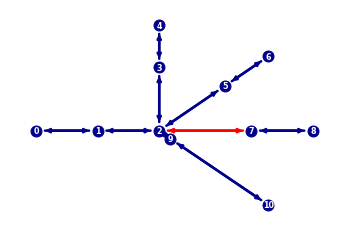

In [7]:
# draw edges, nodes and labels.
colors =['darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=120)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_limited_water_depth.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 2.05,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

In [10]:
draught = opentnsim.strategy.Payload2T(vessel= vessel, Payload_strategy=1056, vessel_type= "Tanker")
draught 

1056 995.4777630730554 1.9098300562505255 Tanker
1056 2357.3339801398893 3.0901699437494736 Tanker
1056 171.52208911192673 1.1803398874989486 Tanker
1056 1044.6032263688046 1.952948260116881 Tanker
1056 1056.6440251292015 1.9635103328589776 Tanker
1056 1056.0063061524618 1.96295099432661 Tanker
1056 1055.9999275090765 1.9629453996310744 Tanker
1056 1055.9960939031682 1.9629420371825557 Tanker
T_Payload2T = 1.96


1.9629453996310744

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [11]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.40
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]


In [12]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,T_strategy,h_min,safety_margin,width
0,2.30,2.5,0.2,150
1,2.25,2.5,0.2,150
2,2.20,2.5,0.2,150
3,2.15,2.5,0.2,150
4,2.10,2.5,0.2,150
5,2.05,2.5,0.2,150
6,2.00,2.5,0.2,150
7,1.95,2.5,0.2,150
8,1.90,2.5,0.2,150
9,1.85,2.5,0.2,150


#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [13]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

In [14]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.50,0.20,150.00,2.84,0.00,0.00,2.50,2.50,1441.73
1,2.25,2.50,0.20,150.00,3.19,1.58,0.05,2.45,2.45,1384.33
2,2.20,2.50,0.20,150.00,3.48,2.23,0.10,2.40,2.40,1326.99
3,2.15,2.50,0.20,150.00,3.74,2.73,0.15,2.35,2.35,1269.71
4,2.10,2.50,0.20,150.00,3.98,3.17,0.20,2.30,2.30,1212.50
5,2.05,2.50,0.20,150.00,4.15,3.56,0.25,2.25,2.25,1155.35
6,2.00,2.50,0.20,150.00,4.36,3.92,0.30,2.20,2.20,1098.26
7,1.95,2.50,0.20,150.00,4.50,4.27,0.35,2.15,2.15,1041.24
8,1.90,2.50,0.20,150.00,4.57,4.57,0.40,2.10,2.10,984.28
9,1.85,2.50,0.20,150.00,4.68,4.68,0.41,2.09,2.05,927.39


#### Provide a group of feasible velocities for each T_strategy

In [15]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
v_df.columns=names
v_df

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,NaN,1.58,2.23,2.73,3.17,3.56,3.92,4.27,4.57,4.68,4.72,4.74,4.74,4.73,4.7,4.65,4.59,4.52,4.43
1,NaN,1.48,2.13,2.63,3.07,3.46,3.82,4.17,4.47,4.58,4.62,4.64,4.64,4.63,4.6,4.55,4.49,4.42,4.33
2,NaN,1.38,2.03,2.53,2.97,3.36,3.72,4.07,4.37,4.48,4.52,4.54,4.54,4.53,4.5,4.45,4.39,4.32,4.23
3,NaN,1.28,1.93,2.43,2.87,3.26,3.62,3.97,4.27,4.38,4.42,4.44,4.44,4.43,4.4,4.35,4.29,4.22,4.13
4,NaN,1.18,1.83,2.33,2.77,3.16,3.52,3.87,4.17,4.28,4.32,4.34,4.34,4.33,4.3,4.25,4.19,4.12,4.03
5,NaN,1.08,1.73,2.23,2.67,3.06,3.42,3.77,4.07,4.18,4.22,4.24,4.24,4.23,4.2,4.15,4.09,4.02,3.93
6,NaN,0.98,1.63,2.13,2.57,2.96,3.32,3.67,3.97,4.08,4.12,4.14,4.14,4.13,4.1,4.05,3.99,3.92,3.83
7,NaN,NaN,1.53,2.03,2.47,2.86,3.22,3.57,3.87,3.98,4.02,4.04,4.04,4.03,4.0,3.95,3.89,3.82,3.73
8,NaN,NaN,1.43,1.93,2.37,2.76,3.12,3.47,3.77,3.88,3.92,3.94,3.94,3.93,3.9,3.85,3.79,3.72,3.63
9,NaN,NaN,1.33,1.83,2.27,2.66,3.02,3.37,3.67,3.78,3.82,3.84,3.84,3.83,3.8,3.75,3.69,3.62,3.53


In [16]:
# create a new table of all the v/strategy combinations
# using the itertools.product is more pro
# but for now we'll just loop
rows = []
for strategy in Strategies:
    max_velocity = strategy['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2)
    for v_feasible_i in v_feasible:
        row = {}
        row.update(strategy)
        row['max_velocity'] = max_velocity
        row['min_velocity'] = min_velocity
        row['stepsize'] = stepsize
        row['v_feasible'] = v_feasible_i
       
        rows.append(row)
v_flat_df = pd.DataFrame(rows)        

    

In [17]:
columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
# select relevant info
# these are all the runs that we want to run a simulation 
runs_df = v_flat_df[columns]
runs_df

,T_strategy,v_feasible,h_min,safety_margin,width
0,2.25,1.58,2.5,0.2,150.0
1,2.25,1.48,2.5,0.2,150.0
2,2.25,1.38,2.5,0.2,150.0
3,2.25,1.28,2.5,0.2,150.0
4,2.25,1.18,2.5,0.2,150.0
...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0
568,1.40,1.23,2.5,0.2,150.0
569,1.40,1.13,2.5,0.2,150.0
570,1.40,1.03,2.5,0.2,150.0


In [18]:
# import IPython.display

# T_strategies = v_flat_df.T_strategy.unique()

# def get_v_feasible_for_T(T_strategy):
#     selected_df = v_flat_df[np.isclose(v_flat_df.T_strategy, T_strategy)]
#     columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
#     return selected_df[columns]

# runs = []
# for T_strategy in T_strategies:
#     v_feasible_df = get_v_feasible_for_T(T_strategy)
#     runs.append(v_feasible_df)




In [19]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
T_strategy.columns = T_names
T_strategy

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,2.3,2.25,2.2,2.15,2.1,2.05,2.0,1.95,1.9,1.85,1.8,1.75,1.7,1.65,1.6,1.55,1.5,1.45,1.4


In [20]:
v_df.T
v_df
max_velocity

4.428522457804811

#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [21]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [22]:
path = nx.dijkstra_path(FG, nodes[2].name, nodes[7].name)

In [23]:
results = []
import time
def run_and_postprocess(row, vessel):
    max_sinkage = (vessel.C_B * ((vessel.B * row['T_strategy']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible']*1.94) ** 2.08) / 20
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel = run_simulation(V_s = row['v_feasible'],T = row['T_strategy'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    result = {}
    result.update(row)
    # result['transport time (s)'] = energycalculation.energy_use["distance"][0]/row['v_feasible']/3600
    result['transport time (s)'] = 150000/row['v_feasible']
    result['Fuel Use (g)'] = energycalculation.energy_use["total_diesel_consumption_C_year_ICE_mass"][0]/3600   #  hour--> sec
    result['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"][0]/3600  #  hour--> sec
    result['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"][0]/3600  #  hour--> sec
    result['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"][0]/3600  #  hour--> sec
    result['Safety (remaining space (m))'] = row['h_min'] - row['T_strategy'] - max_sinkage   
    result['Payload_strategy_tanker (ton)'] = Payload_comupted   
    return result
    
tqdm.tqdm.pandas(desc="Simulating is ongoing")
# predefine the vessel variable
run = functools.partial(run_and_postprocess, vessel=vessel)
results = runs_df.progress_apply(run, axis=1)
results_df = pd.DataFrame(results.values.tolist())

results_df['transport time (hours)'] = results_df['transport time (s)'] / 3600
results_df['CO2 (ton)'] = results_df['CO2 (g)'] / 1000000
results_df['PM10 (kg)'] = results_df['PM10 (g)'] / 1000
results_df['NOx (kg)'] = results_df['NOx (g)'] / 1000
results_df['Fuel Use (ton)'] = results_df['Fuel Use (g)'] / 1000000
results_df['Fuel cost (MGO_600USD/ton)'] = results_df['Fuel Use (ton)']*600   # marine fuel price https://fingfx.thomsonreuters.com/gfx/editorcharts/OIL-SHIPPING/0H001QXRHB2C/index.html
results_df['Carbon cost (EU_27USD/ton)'] = results_df['CO2 (ton)']*27 # the world bank 2020


results_df
    


Simulating is ongoing:   1%|▌                                                          | 5/572 [00:00<00:12, 44.51it/s]

2.4502699711061102
2.4565933430853466
2.4624715635788745
2.4679071188665453
2.472902667157826
2.4774610654664855
2.4815854034538245
2.4000044628548456


Simulating is ongoing:   3%|█▌                                                        | 15/572 [00:00<00:13, 41.86it/s]

2.4091058196592563
2.417757129238805
2.425960120165291
2.4337166012628932
2.441028469806122
2.4478977210584385
2.45432645947392
2.460316911969211
2.465871443819059


Simulating is ongoing:   4%|██▌                                                       | 25/572 [00:00<00:12, 42.28it/s]

2.470992577921571
2.4756830184687413
2.479945680492685
2.483783727432456
2.3505012403669454
2.361666539758281
2.3723825778781835
2.3826507461212394


Simulating is ongoing:   5%|███                                                       | 30/572 [00:00<00:13, 41.06it/s]

2.3924724874566157
2.401849300584605
2.410782744631065
2.4192744444642207
2.4273260967651034
2.4349394769865307
2.4421164473998163
2.448858966457404
2.455169099787876
2.4610490332230452
2.466501088400231


Simulating is ongoing:   8%|████▍                                                     | 44/572 [00:00<00:10, 52.52it/s]

2.4715277416720856
2.4761316473404236
2.480315666657348
2.48408290469899
2.2998548709178945
2.312763902473067
2.3252266646447586
2.337244338344552
2.3488181416616642
2.3599493323930645
2.3706392108429393
2.38088912293812
2.3907004637021005


Simulating is ongoing:  10%|█████▊                                                    | 57/572 [00:01<00:08, 57.92it/s]

2.400074681148219
2.4090132806638733
2.4175178299701696
2.425589964766337
2.433231395189469
2.4404439132564866
2.4472294015030047
2.453589843086956
2.459527333718108
2.4650440958807684
2.4701424959867104


Simulating is ongoing:  11%|██████▍                                                   | 63/572 [00:01<00:10, 49.22it/s]

2.474825065331162
2.4790945260779984
2.4829538240446856
2.250149194297103
2.2645259551377976
2.2784608651126117
2.2919549598167825
2.30500930360693


Simulating is ongoing:  13%|███████▌                                                  | 74/572 [00:01<00:11, 42.86it/s]

2.3176249913229863
2.329803150165837
2.3415449417624403
2.3528515644354786
2.3637242557076648
2.3741642950813784
2.384173007121229
2.3937517649029325
2.4029019938745675


Simulating is ongoing:  15%|████████▌                                                 | 84/572 [00:01<00:12, 39.88it/s]

2.411625176208356
2.4199228557269934
2.427796643512804
2.4352482243295284
2.4422793640297207
2.4488919181548914
2.455087842007347
2.4608692025501764


Simulating is ongoing:  16%|█████████                                                 | 89/572 [00:02<00:13, 36.23it/s]

2.466238192611219
2.4711971480344714
2.475748568662629
2.479895144398316
2.4836397881457937
2.2007642713443722


Simulating is ongoing:  16%|█████████▍                                                | 93/572 [00:02<00:14, 32.45it/s]

2.2164235102009577
2.231646204316201
2.246433279215979
2.260785683611595
2.274704390644919


Simulating is ongoing:  17%|█████████▉                                               | 100/572 [00:02<00:17, 26.26it/s]

2.288190399239617
2.301244735567594
2.3138684546494663
2.3260626421042354
2.33782841605329


Simulating is ongoing:  19%|██████████▌                                              | 106/572 [00:02<00:19, 24.21it/s]

2.349166929230709
2.3600793712892782
2.370566971363296
2.3806310009035583


Simulating is ongoing:  19%|██████████▊                                              | 109/572 [00:02<00:20, 22.94it/s]

2.3902727768396534
2.3994936651112773
2.4082950846385707
2.416678511800739


Simulating is ongoing:  21%|███████████▊                                             | 118/572 [00:03<00:14, 30.77it/s]

2.424645485519214
2.432197613056644
2.439336576676259
2.4460641413420983
2.452382163689936
2.458292602567974
2.463797531541281
2.468899153883216
2.473599820768296
2.477902053659057


Simulating is ongoing:  22%|████████████▋                                            | 127/572 [00:03<00:13, 33.45it/s]

2.4818085722970156
2.4853223303642653
2.1497629015740554
2.1666080105979466
2.1830224258340944
2.199006982885118
2.2145625364634287


Simulating is ongoing:  23%|█████████████▎                                           | 133/572 [00:03<00:11, 39.38it/s]

2.229689961329731
2.2443901532943022
2.2586640303078345
2.2725125336322303
2.2859366291123697
2.298937308556127
2.3115155912320784
2.3236725255107284
2.3354091906512666
2.346726698763803
2.3576261969700636
2.368108869786099


Simulating is ongoing:  25%|██████████████▍                                          | 145/572 [00:03<00:08, 47.84it/s]

2.378175941758653
2.3878286803990756
2.397068399454946
2.405896462576426
2.41431428744505
2.422323350444416
2.4299251919757503
2.4371214225412934
2.443913729752688
2.450303886466529
2.456293760299342


Simulating is ongoing:  27%|███████████████▌                                         | 156/572 [00:04<00:09, 43.84it/s]

2.4618853248620685
2.4670806731541357
2.4718820337170326
2.476291790369375
2.4803125066781653
2.4839469568336416
2.105033515961286
2.1227978183649037


Simulating is ongoing:  28%|████████████████                                         | 161/572 [00:04<00:10, 40.65it/s]

2.14013804358627
2.1570549585830343
2.173549346635684
2.18962200809358
2.205273761161807
2.220505442757369
2.2353179094281526
2.249712038333355


Simulating is ongoing:  30%|████████████████▉                                        | 170/572 [00:04<00:10, 37.56it/s]

2.26368872831162
2.277248901027453
2.29039350221651
2.303123503036885
2.315439901535631
2.3273437242558175
2.3388360279860865
2.3499179016820317


Simulating is ongoing:  31%|█████████████████▊                                       | 179/572 [00:04<00:10, 39.08it/s]

2.3605904685819095
2.37085488853974
2.3807123606067804
2.3901641259043593
2.3992114708273773
2.407855730634331
2.4160982934901374
2.423940605039579
2.431384173612198
2.4384305761790235


Simulating is ongoing:  33%|██████████████████▊                                      | 189/572 [00:04<00:08, 42.81it/s]

2.445081465215043
2.451338576665367
2.457203739262101
2.4626788855249266
2.4677660648763036
2.4724674594587186
2.476785403458863
2.4807224070693916

Simulating is ongoing:  35%|███████████████████▉                                     | 200/572 [00:05<00:08, 45.47it/s]


2.484281186720946
2.0938704354971436
2.111712486054836
2.1291387138201436
2.146149852574178
2.1627466513283946
2.178929874996892
2.1947003051189764
2.2100587406311103
2.225005998695274
2.239542915592488


Simulating is ongoing:  36%|████████████████████▋                                    | 207/572 [00:05<00:07, 51.15it/s]

2.253670347676577
2.267389172403272
2.280700289458555
2.293604621952563
2.306103117738618
2.3181967508389416
2.3298865229952064
2.3411734653694185
2.352058640410804
2.3625431439002256


Simulating is ongoing:  38%|█████████████████████▋                                   | 218/572 [00:05<00:07, 47.62it/s]

2.372628107212631
2.3823146998186546
2.391604132065239
2.4004976582752
2.408996580221173
2.417102251033394
2.424816079620432
2.4321395356961526
2.4390741555280235
2.4456215485585027


Simulating is ongoing:  40%|██████████████████████▊                                  | 229/572 [00:05<00:07, 47.06it/s]

2.4517834050807075
2.457561505212995
2.4629577294812277
2.467974071424317
2.472612652777899
2.4768757419985
2.4807657771977945
2.484285395023656
2.0956902474174677
2.1133035640746


Simulating is ongoing:  42%|███████████████████████▊                                 | 239/572 [00:05<00:07, 43.14it/s]

2.1305099016753983
2.1473099721138174
2.163704501923433
2.1796942329270252
2.1952799229186577
2.2104623463981183
2.2252422953633406
2.2396205801487916


Simulating is ongoing:  43%|████████████████████████▎                                | 244/572 [00:06<00:08, 40.93it/s]

2.253598030342594
2.2671754957609336
2.2803538475088123
2.293133979123334
2.3055168078144015
2.3175032758112017
2.329094351831756


Simulating is ongoing:  44%|█████████████████████████▏                               | 253/572 [00:06<00:09, 35.26it/s]

2.3402910326894664
2.3510943450413695
2.361505347325811
2.3715251318798254
2.3811548272923027
2.3903956010070626
2.399248662226471


Simulating is ongoing:  46%|██████████████████████████                               | 261/572 [00:06<00:09, 32.72it/s]

2.4077152651538842
2.4157967126392093
2.4234943602911607
2.430809621144613
2.4377439709852218
2.444298954464041


Simulating is ongoing:  46%|██████████████████████████▍                              | 265/572 [00:06<00:09, 31.87it/s]

2.4504761921678577
2.456277388856281
2.4617043431401857
2.466758958963266
2.471443259367134
2.475759403195976
2.4797097056521316


Simulating is ongoing:  48%|███████████████████████████▏                             | 273/572 [00:07<00:09, 30.05it/s]

2.48329666399734
2.4865229902971557
2.101320503466886
2.1186161048075123
2.135513771055412


Simulating is ongoing:  48%|███████████████████████████▌                             | 277/572 [00:07<00:09, 29.53it/s]

2.1520141952499348
2.1681180846261765
2.1838261612280245
2.1991391625777323
2.214057842376212
2.228582971266849
2.2427153376507527


Simulating is ongoing:  49%|████████████████████████████▏                            | 283/572 [00:07<00:09, 29.25it/s]

2.2564557485630186
2.2698050306129
2.2827640310054598
2.2953336186392947
2.3075146853030377
2.319308146967685
2.330714945197525


Simulating is ongoing:  51%|████████████████████████████▉                            | 291/572 [00:07<00:08, 32.40it/s]

2.34173604869207
2.3523724549699234
2.362625192216429
2.3724953213238575
2.381983938137278
2.3910921759513304
2.399821208281899
2.4081722519695345
2.4161465706553975


Simulating is ongoing:  53%|██████████████████████████████▍                          | 305/572 [00:07<00:07, 38.04it/s]

2.4237454787063903
2.4309703456587277
2.437822601285811
2.444303741408711
2.4504153346050574
2.456159030012987
2.461536566484175
2.466549783421173
2.4712006337400747


Simulating is ongoing:  54%|██████████████████████████████▊                          | 309/572 [00:08<00:08, 32.71it/s]

2.475491199562205
2.4794237114660262
2.4830005724773296
2.486224388511151
2.1105724180320813


Simulating is ongoing:  55%|███████████████████████████████▏                         | 313/572 [00:08<00:08, 31.07it/s]

2.12746665078629
2.1439721830874072
2.160089691891837
2.175819868022296
2.1911634167666354
2.206121058531874
2.2206935295282424
2.23488158251527


Simulating is ongoing:  56%|████████████████████████████████                         | 322/572 [00:08<00:07, 33.39it/s]

2.2486859875981158
2.2621075330835003
2.275147026398054
2.2878052950862626
2.3000831878827173
2.311981575880851
2.3235013537952725
2.334643441339957


Simulating is ongoing:  58%|████████████████████████████████▉                        | 331/572 [00:08<00:06, 35.76it/s]

2.34540878473439
2.355798358348364
2.365813166506745
2.375454245482317
2.3847226656895337
2.3936195341233497
2.4021459970665746
2.410303243121274


Simulating is ongoing:  59%|█████████████████████████████████▉                       | 340/572 [00:08<00:06, 37.52it/s]

2.418092506604051
2.425515071380088
2.432572275203598
2.439265514668095
2.4455962508820313
2.451566016022003
2.457176420955592
2.462429164181992


Simulating is ongoing:  61%|██████████████████████████████████▊                      | 349/572 [00:09<00:05, 38.91it/s]

2.46732604241785
2.4718689632591135
2.4760599605085734
2.479901212981004
2.4833950679366263
2.486544070816578
2.121542341067051
2.1379949848932753
2.1540682801456734


Simulating is ongoing:  62%|███████████████████████████████████▌                     | 357/572 [00:09<00:05, 38.38it/s]

2.1697628889407246
2.1850794869793333
2.200018764150156
2.214581425154041
2.228768190198769
2.2425797957149434
2.256016995149093
2.2690805597995167


Simulating is ongoing:  64%|████████████████████████████████████▍                    | 366/572 [00:09<00:05, 39.73it/s]

2.2817712797187286
2.2940899647030744
2.3060374453389136
2.3176145741558467
2.3288222268715613
2.339661303746555
2.35013273106777
2.3602374627669724
2.36997648220388


Simulating is ongoing:  66%|█████████████████████████████████████▍                   | 376/572 [00:09<00:04, 42.32it/s]

2.3793508041256515
2.3883614768333543
2.3970095845855424
2.405296250272053
2.413222638404688
2.420789958471642
2.4279994687260373
2.4348524804767115
2.441350362987213
2.4474945490918705


Simulating is ongoing:  67%|██████████████████████████████████████▍                  | 386/572 [00:10<00:04, 42.47it/s]

2.4532865416896836
2.458727921300204
2.4638203549367774
2.468565606619729
2.4729655499677845
2.477022183458771
2.48073764917989
2.4841142562323406


Simulating is ongoing:  68%|██████████████████████████████████████▉                  | 391/572 [00:10<00:04, 41.80it/s]

2.4871545104893453
2.1357120032796675
2.1516485626177575
2.1672153041870192
2.1824128777182685
2.197241946369193
2.2117031873089106
2.2257972923602702
2.2395249686688983


Simulating is ongoing:  70%|███████████████████████████████████████▉                 | 401/572 [00:10<00:04, 42.43it/s]

2.2528869394355007
2.2658839446927606
2.278516742144866
2.290786108067479
2.3026928382950365
2.314237749266348
2.3254216791775923
2.336245489225348
2.3467100649676063


Simulating is ongoing:  72%|████████████████████████████████████████▉                | 411/572 [00:10<00:03, 42.75it/s]

2.3568163178043684
2.366565186607034
2.375957639501629
2.384994675842447
2.3936773283888813
2.402006665725356
2.4099837949574394
2.4176098647294317
2.424886068616177


Simulating is ongoing:  74%|█████████████████████████████████████████▉               | 421/572 [00:10<00:03, 43.13it/s]

2.431813648956546
2.4383939012070304
2.4446281789139843
2.4505178994341277
2.4560645505551175
2.461269698223958
2.4661349956431944
2.470662194083099
2.4748531558754565


Simulating is ongoing:  74%|██████████████████████████████████████████▍              | 426/572 [00:11<00:03, 41.96it/s]

2.4787098702225667
2.482234472709678
2.4854292697879745
2.1527718323267866
2.168123492160027
2.1831150383939364
2.1977471107384465
2.212020362264972
2.225935460014223


Simulating is ongoing:  76%|███████████████████████████████████████████▍             | 436/572 [00:11<00:03, 42.09it/s]

2.2394930856249515
2.252693936023453
2.265538724150502
2.2780281797546467
2.2901630502417634
2.3019441015862108
2.313372119321809
2.3244479096179425
2.3351723004397478


Simulating is ongoing:  78%|████████████████████████████████████████████▍            | 446/572 [00:11<00:02, 42.32it/s]

2.345546142816857
2.3555703122291924
2.3652457101165263
2.3745732655419425
2.3835539370170595
2.39218871452361
2.4004786217474767
2.4084247185683134
2.416028103836121


Simulating is ongoing:  80%|█████████████████████████████████████████████▍           | 456/572 [00:11<00:02, 43.44it/s]

2.423289918489678
2.4302113490666075
2.43679363168389
2.443038056567275
2.4489459732460666
2.4545187965449258
2.459758013548226
2.464665191762028
2.469241988767735


Simulating is ongoing:  81%|██████████████████████████████████████████████▍          | 466/572 [00:12<00:02, 40.34it/s]

2.473490163756663
2.4774115914755375
2.4810082793115487
2.4842823885465486
2.4872362612754175
2.170884423837733
2.1856232353680394
2.200011744165018


Simulating is ongoing:  82%|██████████████████████████████████████████████▉          | 471/572 [00:12<00:02, 39.45it/s]

2.2140505809113846
2.2277403896492927
2.2410818283913354
2.2540755697564987
2.266722301672495
2.2790227281219044
2.290977569936592
2.3025875656722152


Simulating is ongoing:  84%|███████████████████████████████████████████████▋         | 479/572 [00:12<00:02, 35.74it/s]

2.3138534725325206
2.324776067389671
2.3353561478758222
2.3455945335749266
2.355492067328624
2.3650496166513952
2.374268075291906


Simulating is ongoing:  85%|████████████████████████████████████████████████▌        | 487/572 [00:12<00:02, 35.34it/s]

2.3831483649436933
2.3916914371341367
2.399898275313174
2.4077698971748394
2.4153073572443935
2.4225117497746855
2.4293842120046416
2.4359259278431824


Simulating is ongoing:  87%|█████████████████████████████████████████████████▎       | 495/572 [00:12<00:02, 34.67it/s]

2.442138132054918
2.4480221150445685
2.453579228364182
2.458810891091944
2.4637185972846996
2.4683039247571923
2.4725685455284854
2.476514238390933


Simulating is ongoing:  88%|██████████████████████████████████████████████████▎      | 505/572 [00:13<00:01, 38.90it/s]

2.480142904222604
2.4834565849162056
2.4864574871724243
2.1898725863934447
2.203973539076885
2.2177341057340323
2.231154909005605
2.2442365849376413


Simulating is ongoing:  89%|██████████████████████████████████████████████████▊      | 510/572 [00:13<00:01, 39.92it/s]

2.2569797835979424
2.2693851697411844
2.2814534235126107
2.293185241217804
2.3045813361405507
2.3156424394331663
2.3263693010761024
2.3367626909193135
2.34682339981241


Simulating is ongoing:  91%|███████████████████████████████████████████████████▌     | 518/572 [00:13<00:01, 37.18it/s]

2.3565522408381128
2.3659500506606896
2.3750176909933303
2.383756050224514
2.3921660451952085
2.4002486231739746
2.408004764041826
2.41543548272935


Simulating is ongoing:  92%|████████████████████████████████████████████████████▌    | 528/572 [00:13<00:01, 39.03it/s]

2.4225418319382146
2.429324905201031
2.43578584033293
2.4419258233490524
2.4477460929337105
2.453247945572625
2.4584327414873304
2.463301911548887
2.4678569654013716


Simulating is ongoing:  94%|█████████████████████████████████████████████████████▍   | 536/572 [00:13<00:00, 37.18it/s]

2.472099501098795
2.4760312166586838
2.4796539240829483
2.4829695666109783
2.4859802402917026
2.488688221467245
2.2109136468622417
2.224321647723367


Simulating is ongoing:  95%|██████████████████████████████████████████████████████▏  | 544/572 [00:14<00:00, 34.70it/s]

2.2373993455689374
2.2501473572872177
2.2625663133410887
2.2746568583947355
2.2864196520079156
2.2978553693676536
2.308964702078232


Simulating is ongoing:  97%|███████████████████████████████████████████████████████  | 552/572 [00:14<00:00, 33.67it/s]

2.3197483590274905
2.330207067302645
2.3403415731998103
2.350152643313729
2.3596410657236784
2.368807651292233
2.377653235081977
2.3861786779164382


Simulating is ongoing:  98%|███████████████████████████████████████████████████████▊ | 560/572 [00:14<00:00, 34.03it/s]

2.3943848680954027
2.402272723291423
2.409843192653886
2.4170972591496267
2.4240359421809425
2.430660300522029
2.4369714356354244


Simulating is ongoing: 100%|████████████████████████████████████████████████████████▊| 570/572 [00:14<00:00, 39.26it/s]

2.4429704954281233
2.4486586785401094
2.4540372392606105
2.459107493212784
2.463870823968064
2.46832869081371
2.4724826379559466
2.476334305542373
2.47988544302103


Simulating is ongoing: 100%|█████████████████████████████████████████████████████████| 572/572 [00:14<00:00, 38.27it/s]

2.483137925554205
2.4860937745066174
2.488755183495298


,T_strategy,v_feasible,h_min,safety_margin,width,transport time (s),Fuel Use (g),CO2 (g),PM10 (g),NOx (g),Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),CO2 (ton),PM10 (kg),NOx (kg),Fuel Use (ton),Fuel cost (MGO_600USD/ton),Carbon cost (EU_27USD/ton)
0,2.25,1.58,2.5,0.2,150.0,94936.708861,3117.135643,9889.821268,8.283210,168.131306,0.200270,1384.325488,26.371308,0.009890,0.008283,0.168131,0.003117,1.870281,0.267025
1,2.25,1.48,2.5,0.2,150.0,101351.351351,3072.823650,9749.231400,8.670623,173.260040,0.206593,1384.325488,28.153153,0.009749,0.008671,0.173260,0.003073,1.843694,0.263229
2,2.25,1.38,2.5,0.2,150.0,108695.652174,3096.842673,9825.437210,9.102057,180.027031,0.212472,1384.325488,30.193237,0.009825,0.009102,0.180027,0.003097,1.858106,0.265287
3,2.25,1.28,2.5,0.2,150.0,117187.500000,3145.793630,9980.745245,9.574362,187.761032,0.217907,1384.325488,32.552083,0.009981,0.009574,0.187761,0.003146,1.887476,0.269480
4,2.25,1.18,2.5,0.2,150.0,127118.644068,3190.702329,10123.228298,10.059256,195.624238,0.222903,1384.325488,35.310734,0.010123,0.010059,0.195624,0.003191,1.914421,0.273327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0,112781.954887,2689.421394,8532.800605,8.687548,167.996164,1.076334,418.202940,31.328321,0.008533,0.008688,0.167996,0.002689,1.613653,0.230386
568,1.40,1.23,2.5,0.2,150.0,121951.219512,2779.154066,8817.497899,9.157621,176.283652,1.079885,418.202940,33.875339,0.008817,0.009158,0.176284,0.002779,1.667492,0.238072
569,1.40,1.13,2.5,0.2,150.0,132743.362832,2904.611101,9215.538857,9.731554,186.630912,1.083138,418.202940,36.873156,0.009216,0.009732,0.186631,0.002905,1.742767,0.248820
570,1.40,1.03,2.5,0.2,150.0,145631.067961,3074.467846,9754.447983,10.443911,199.677234,1.086094,418.202940,40.453074,0.009754,0.010444,0.199677,0.003074,1.844681,0.263370


#### Advanced Parallel Coordinates Plot

In [24]:
strategies_df = results_df

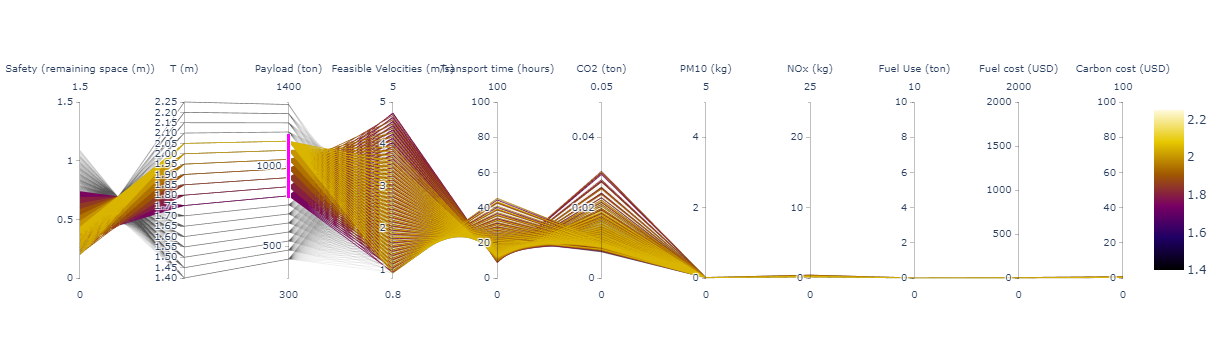

In [29]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T_strategy'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 2.25,
                   cmax = 1.4),
        dimensions = list([
            dict(range = [0,1.5],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,
                            1.95,2.00,2.05,2.10,2.15,2.20,2.25],
                 ticktext = ['1.40','1.45','1.50','1.55','1.60','1.65','1.70','1.75','1.80','1.85','1.90',
                            '1.95','2.00','2.05','2.10','2.15','2.20','2.25'],
                 label = "T (m)", values = strategies_df['T_strategy']),
            dict(range = [300,1400],
                 constraintrange = [800,1200],
                 label = "Payload (ton)", values = strategies_df['Payload_strategy_tanker (ton)']),
            dict(range = [0.8,5],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible']),                       
             dict(range = [0,100],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,0.05],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,5],                
                 label = 'PM10 (kg)', values = strategies_df['PM10 (kg)']),
            dict(range = [0,25],                 
                 label = 'NOx (kg)', values = strategies_df['NOx (kg)']),
            dict(range = [0,10],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
            dict(range = [0,2000],                 
                 label = 'Fuel cost (USD)', values = strategies_df['Fuel cost (MGO_600USD/ton)']),
            dict(range = [0,100],
                 # constraintrange = [8,20],
                 label = 'Carbon cost (USD)', values = strategies_df['Carbon cost (EU_27USD/ton)']),            
           
        ]),
    )
)
fig.show()

In [26]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_and_policies.html")

In [27]:
%%html
<iframe src="C:/interactiveCharts/parallel-coordinate-plot-plotly.html" width="800" height="600" title="parallel coordinate chart with plotly" style="border:none"></iframe>